In [1]:
!git clone https://github.com/deepanshudashora/Beluga.git

Cloning into 'Beluga'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 14 (delta 3), reused 11 (delta 3), pack-reused 0
Unpacking objects: 100% (14/14), 5.88 KiB | 1.18 MiB/s, done.


In [ ]:
!pip3 install torch_lr_finder

In [1]:
# Initialized Logger
import torch
import torch.optim as optim
from torchvision import datasets
import albumentations as A
from torchsummary import summary
from albumentations.pytorch import ToTensorV2
#from src.model import Net
from Beluga.utils import get_device, \
                  fit_model, plot_accuracy_report, \
                  show_random_results, plot_misclassified, \
                  calculate_accuracy_per_class
from Beluga.dataset import dataset_stats,\
                        visualize_images,\
                        visualize_augmentated_images,\
                        Cifar10SearchDataset
from Beluga.model import CustomResnet

CODE BLOCK: 2

In [2]:
# CUDA?
device = get_device()
print("Available Device :: ", device)

INFO:Beluga.utils:device: cuda


Available Device ::  cuda


CODE BLOCK: 3

In [3]:
sample = datasets.CIFAR10('./data',train=True,download=True)
sample_data = sample.data

mean,std,var = dataset_stats(sample_data)
print(f"SHAPE of Images {sample_data.shape}")
print(f"MEAN of dataset {mean}")
print(f"STD of dataset {std}")
print(f"VAR of dataset {var}")

Files already downloaded and verified
SHAPE of Images (50000, 32, 32, 3)
MEAN of dataset [0.49139968 0.48215841 0.44653091]
STD of dataset [0.24703223 0.24348513 0.26158784]
VAR of dataset [15.56135559 15.11767693 17.44919073]


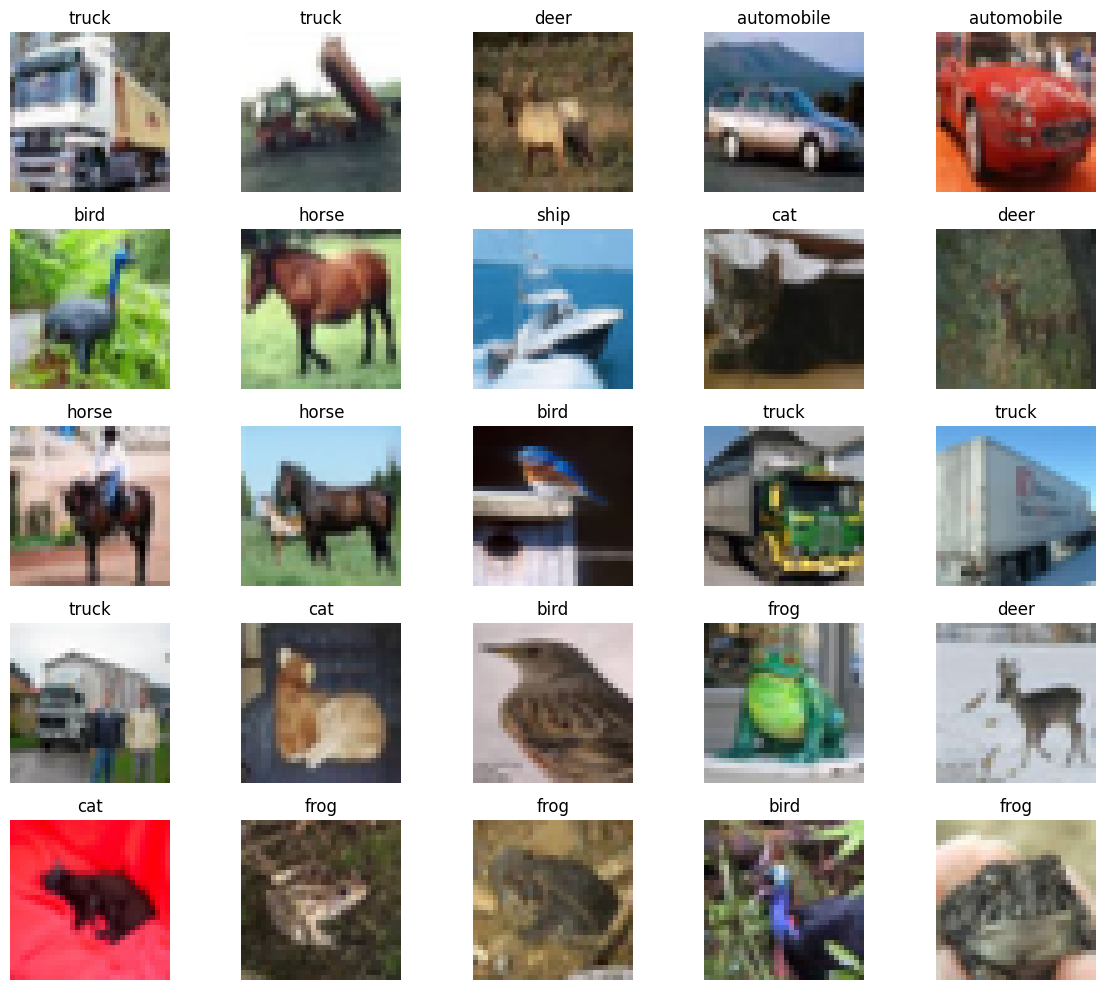

In [4]:
visualize_images(sample,(5,5))

/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:133: FutureWarning: IAAFliplr is deprecated. Please use HorizontalFlip instead.
  warnings.warn("IAAFliplr is deprecated. Please use HorizontalFlip instead.", FutureWarning)


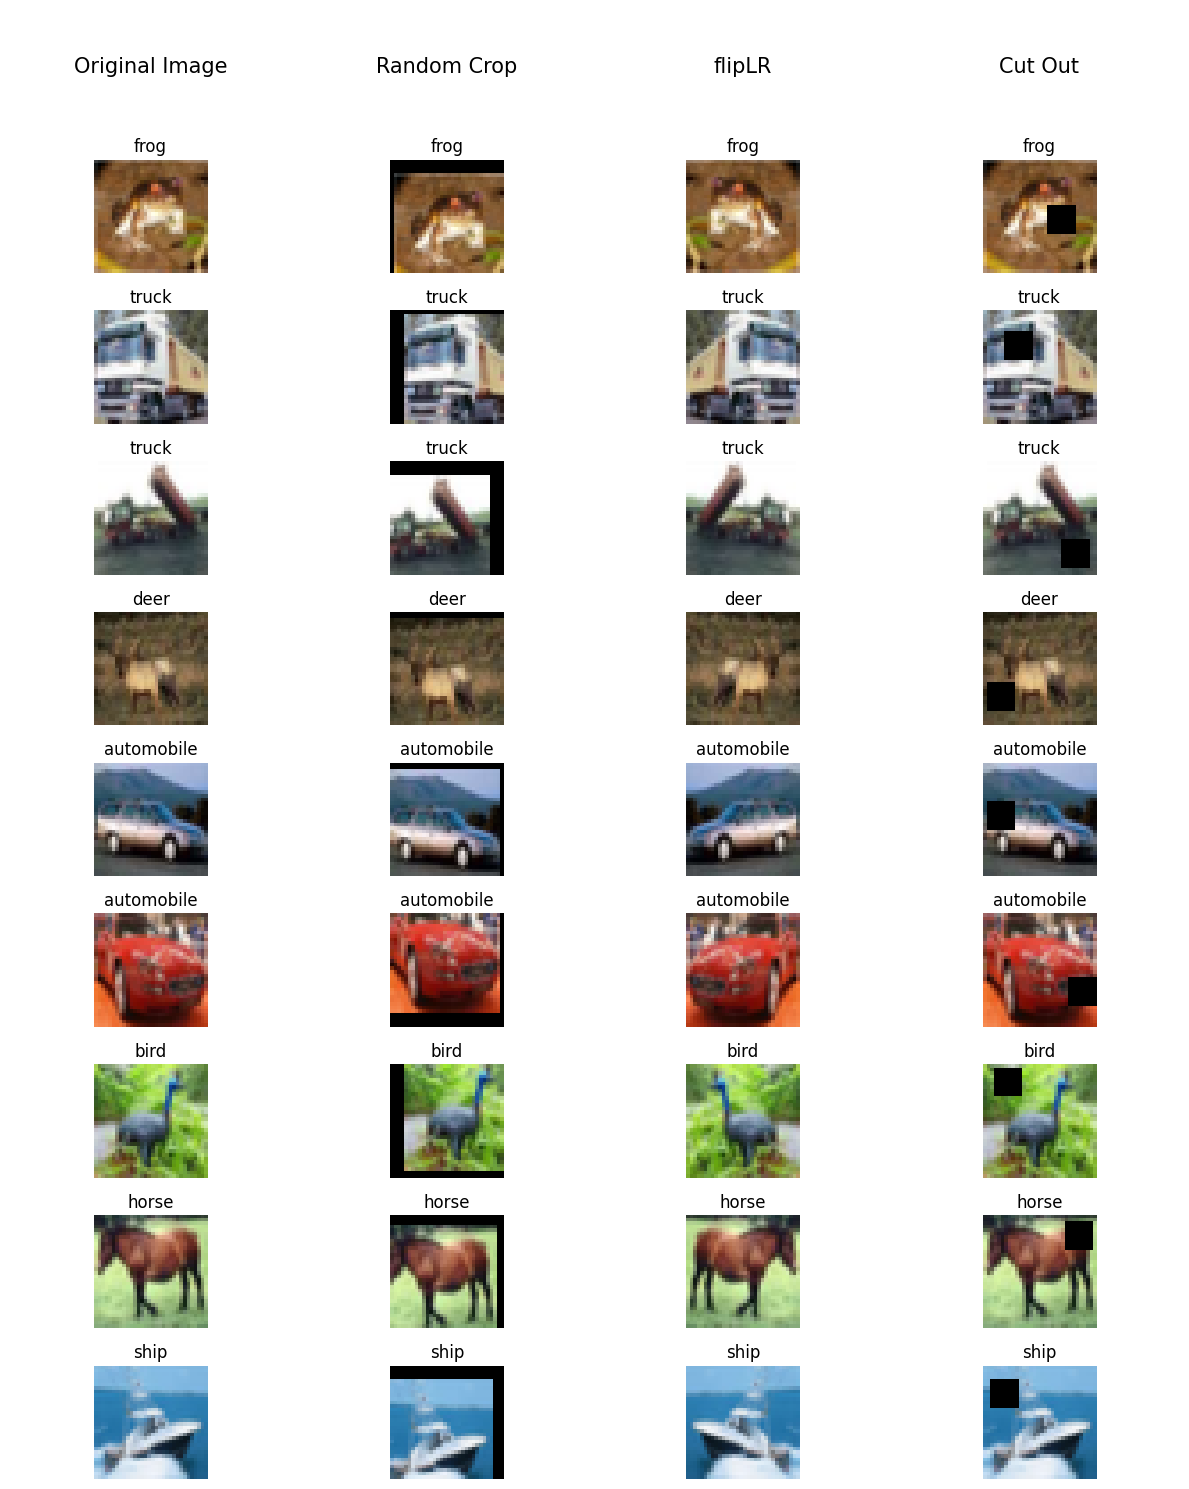

In [5]:
aug_details = {
    'Original Image': None,
    'Random Crop': A.Sequential([A.CropAndPad(px=4, keep_size=False), #padding of 4, keep_size=True by default
                  A.RandomCrop(32,32)]),
    'flipLR':A.IAAFliplr (always_apply=True),
    'Cut Out': A.CoarseDropout(max_holes=1, max_height=8, max_width=8, min_holes=1, min_height=8,
                               min_width=8, fill_value=[0.49139968, 0.48215841, 0.44653091], always_apply=True),
      }

visualize_augmentated_images(sample,aug_details)

In [6]:
train_transforms = A.Compose(
    [
      A.Normalize(mean, std),
      A.PadIfNeeded(40, 40, p=1),
      A.RandomCrop(32, 32, p=1),
      A.IAAFliplr(always_apply=True),
      A.CoarseDropout(max_holes=1, max_height=8, max_width=8, min_holes=1, min_height=8,
                            min_width=8, fill_value=[0.49139968, 0.48215841, 0.44653091], always_apply=True),
      ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
      A.Normalize(mean, std),
      ToTensorV2(),
    ]
)

train = Cifar10SearchDataset(root='./data', train=True,
                                        download=True, transform=train_transforms)
test = Cifar10SearchDataset(root='./data', train=False,
                                       download=True, transform=test_transforms)

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=0, pin_memory=True)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

Files already downloaded and verified
Files already downloaded and verified
CUDA Available? True


In [7]:
model = CustomResnet().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.47E-02


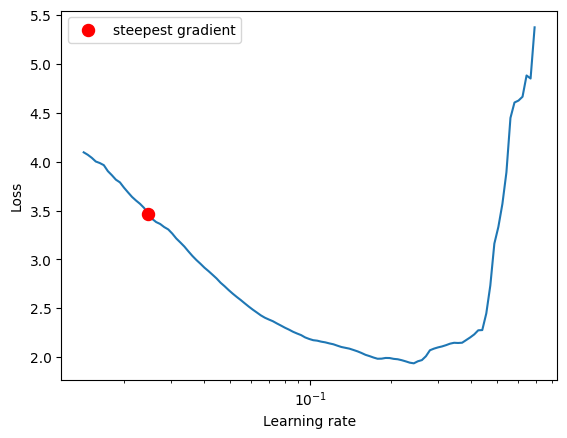

In [8]:
# LR calculation
from torch_lr_finder import LRFinder

model = CustomResnet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [9]:
training_parameters = {"learning_rate":0.01,
                       "max_lr":2.47E-02,
                       "max_at":5/24,
                       "num_epochs":24,
                       "weight_decay":1e-4
                       }
train_losses, test_losses, train_acc, test_acc = fit_model(model,training_parameters,train_loader,test_loader,device)

Epoch 1


Train: Loss=0.9122 Batch_id=97 Accuracy=51.48: 100%|██████████| 98/98 [00:53<00:00,  1.85it/s]


Test set: Average loss: 0.0469, Accuracy: 5112/10000 (51.12%)

Epoch 2


Train: Loss=0.8502 Batch_id=97 Accuracy=67.81: 100%|██████████| 98/98 [00:53<00:00,  1.83it/s]


Test set: Average loss: 0.0249, Accuracy: 7245/10000 (72.45%)

Epoch 3


Train: Loss=0.8496 Batch_id=97 Accuracy=73.03: 100%|██████████| 98/98 [00:53<00:00,  1.84it/s]


Test set: Average loss: 0.0354, Accuracy: 6696/10000 (66.96%)

Epoch 4


Train: Loss=0.6268 Batch_id=97 Accuracy=74.78: 100%|██████████| 98/98 [00:53<00:00,  1.83it/s]


Test set: Average loss: 0.0250, Accuracy: 7415/10000 (74.15%)

Epoch 5


Train: Loss=0.6319 Batch_id=97 Accuracy=77.60: 100%|██████████| 98/98 [00:53<00:00,  1.84it/s]


Test set: Average loss: 0.0184, Accuracy: 7484/10000 (74.84%)

Epoch 6


Train: Loss=0.6546 Batch_id=97 Accuracy=79.43: 100%|██████████| 98/98 [00:53<00:00,  1.84it/s]


Test set: Average loss: 0.0220, Accuracy: 7368/10000 (73.68%)

Epoch 7


Train: Loss=0.5286 Batch_id=97 Accuracy=81.00: 100%|██████████| 98/98 [00:53<00:00,  1.83it/s]


Test set: Average loss: 0.0216, Accuracy: 7500/10000 (75.00%)

Epoch 8


Train: Loss=0.5556 Batch_id=97 Accuracy=81.80: 100%|██████████| 98/98 [00:52<00:00,  1.85it/s]


Test set: Average loss: 0.0220, Accuracy: 7521/10000 (75.21%)

Epoch 9


Train: Loss=0.5963 Batch_id=97 Accuracy=82.39: 100%|██████████| 98/98 [00:52<00:00,  1.87it/s]


Test set: Average loss: 0.0165, Accuracy: 7834/10000 (78.34%)

Epoch 10


Train: Loss=0.4549 Batch_id=97 Accuracy=83.46: 100%|██████████| 98/98 [00:53<00:00,  1.83it/s]


Test set: Average loss: 0.0140, Accuracy: 8205/10000 (82.05%)

Epoch 11


Train: Loss=0.5565 Batch_id=97 Accuracy=83.86: 100%|██████████| 98/98 [00:52<00:00,  1.85it/s]


Test set: Average loss: 0.0159, Accuracy: 7975/10000 (79.75%)

Epoch 12


Train: Loss=0.4342 Batch_id=97 Accuracy=84.85: 100%|██████████| 98/98 [00:53<00:00,  1.85it/s]


Test set: Average loss: 0.0148, Accuracy: 8211/10000 (82.11%)

Epoch 13


Train: Loss=0.4854 Batch_id=97 Accuracy=85.03: 100%|██████████| 98/98 [00:53<00:00,  1.83it/s]


Test set: Average loss: 0.0185, Accuracy: 8189/10000 (81.89%)

Epoch 14


Train: Loss=0.4303 Batch_id=97 Accuracy=85.57: 100%|██████████| 98/98 [00:52<00:00,  1.86it/s]


Test set: Average loss: 0.0119, Accuracy: 8390/10000 (83.90%)

Epoch 15


Train: Loss=0.3914 Batch_id=97 Accuracy=86.31: 100%|██████████| 98/98 [00:52<00:00,  1.85it/s]


Test set: Average loss: 0.0137, Accuracy: 8484/10000 (84.84%)

Epoch 16


Train: Loss=0.3900 Batch_id=97 Accuracy=86.94: 100%|██████████| 98/98 [00:53<00:00,  1.84it/s]


Test set: Average loss: 0.0160, Accuracy: 8306/10000 (83.06%)

Epoch 17


Train: Loss=0.5261 Batch_id=97 Accuracy=87.66: 100%|██████████| 98/98 [00:53<00:00,  1.85it/s]


Test set: Average loss: 0.0116, Accuracy: 8458/10000 (84.58%)

Epoch 18


Train: Loss=0.3988 Batch_id=97 Accuracy=88.77: 100%|██████████| 98/98 [00:52<00:00,  1.85it/s]


Test set: Average loss: 0.0141, Accuracy: 8480/10000 (84.80%)

Epoch 19


Train: Loss=0.2974 Batch_id=97 Accuracy=89.65: 100%|██████████| 98/98 [00:53<00:00,  1.84it/s]


Test set: Average loss: 0.0088, Accuracy: 8771/10000 (87.71%)

Epoch 20


Train: Loss=0.2862 Batch_id=97 Accuracy=90.65: 100%|██████████| 98/98 [00:52<00:00,  1.86it/s]


Test set: Average loss: 0.0117, Accuracy: 8729/10000 (87.29%)

Epoch 21


Train: Loss=0.2322 Batch_id=97 Accuracy=92.14: 100%|██████████| 98/98 [00:52<00:00,  1.87it/s]


Test set: Average loss: 0.0101, Accuracy: 8950/10000 (89.50%)

Epoch 22


Train: Loss=0.1637 Batch_id=97 Accuracy=93.88: 100%|██████████| 98/98 [00:52<00:00,  1.86it/s]


Test set: Average loss: 0.0064, Accuracy: 9043/10000 (90.43%)

Epoch 23


Train: Loss=0.0748 Batch_id=97 Accuracy=95.41: 100%|██████████| 98/98 [00:52<00:00,  1.86it/s]


Test set: Average loss: 0.0075, Accuracy: 9147/10000 (91.47%)

Epoch 24


Train: Loss=0.1034 Batch_id=97 Accuracy=96.89: 100%|██████████| 98/98 [00:52<00:00,  1.88it/s]


Test set: Average loss: 0.0065, Accuracy: 9173/10000 (91.73%)



In [10]:
test_loss_cpu = []
for i in test_losses:
  test_loss_cpu.append(i.cpu().numpy())

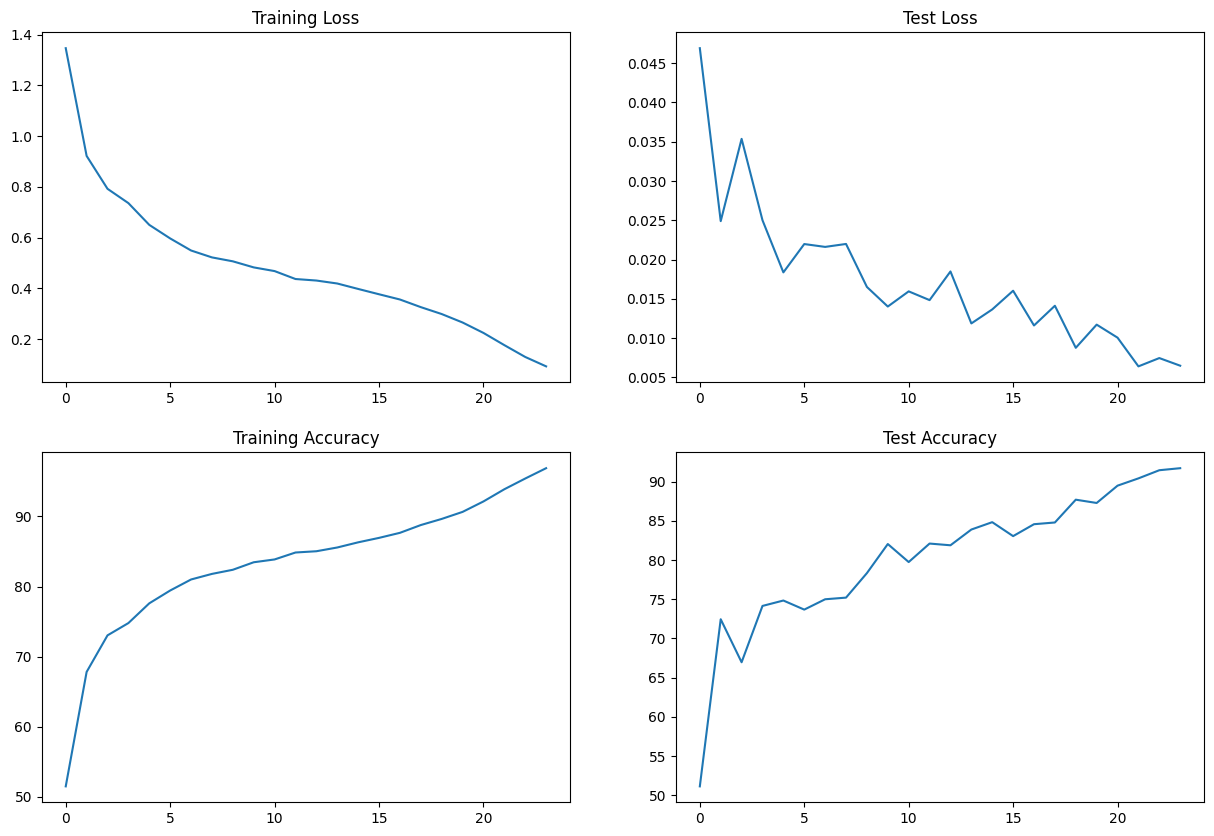

In [11]:
plot_accuracy_report(train_losses, test_loss_cpu, train_acc, test_acc)

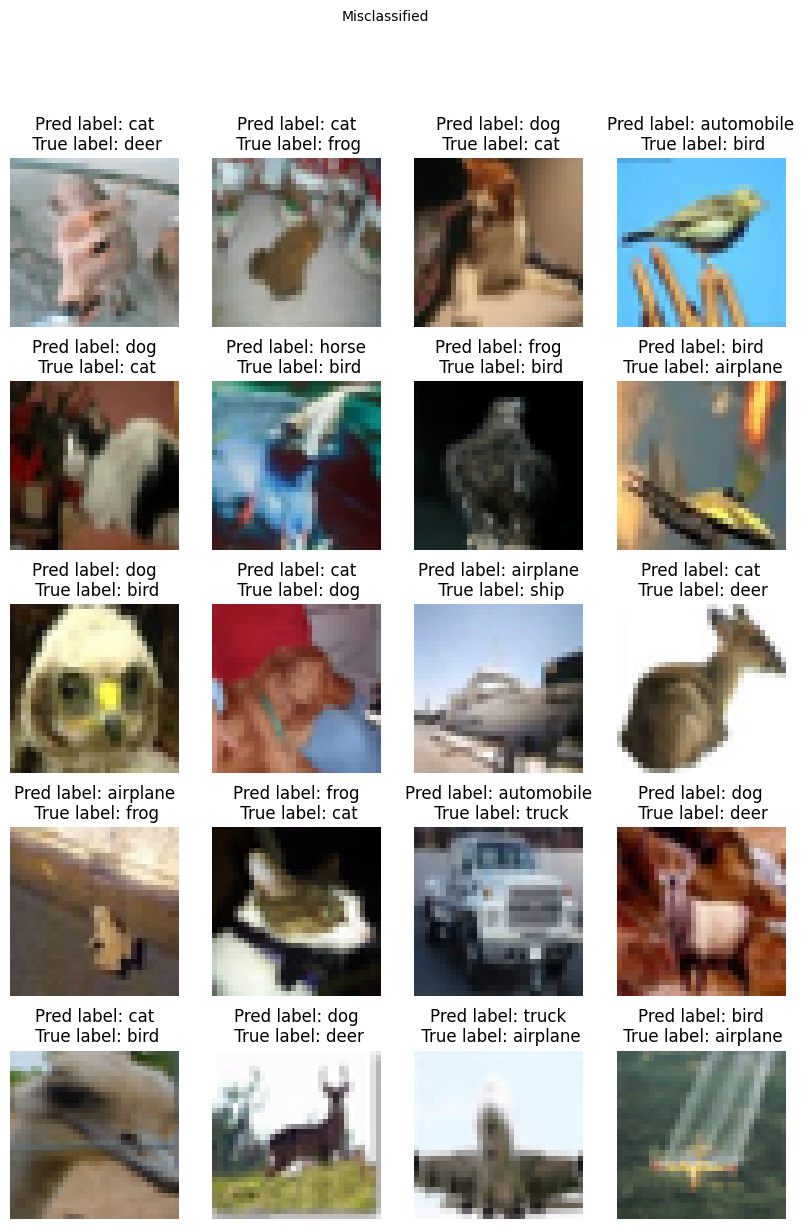

In [12]:
# from torchvision import transforms
# import matplotlib.pyplot as plt
# import numpy as np

grid_size = (4,4)
plot_misclassified(model,test_loader,test,device,mean,std)


Accuracy of airplane : 100 %

Accuracy of automobile : 100 %

Accuracy of  bird : 84 %

Accuracy of   cat : 88 %

Accuracy of  deer : 72 %

Accuracy of   dog : 100 %

Accuracy of  frog : 85 %

Accuracy of horse : 84 %

Accuracy of  ship : 88 %

Accuracy of truck : 87 %
{'airplane': 100.0, 'automobile': 100.0, 'bird': 84.0, 'cat': 88.88888888888889, 'deer': 72.22222222222223, 'dog': 100.0, 'frog': 85.71428571428571, 'horse': 84.61538461538461, 'ship': 88.0, 'truck': 87.5}


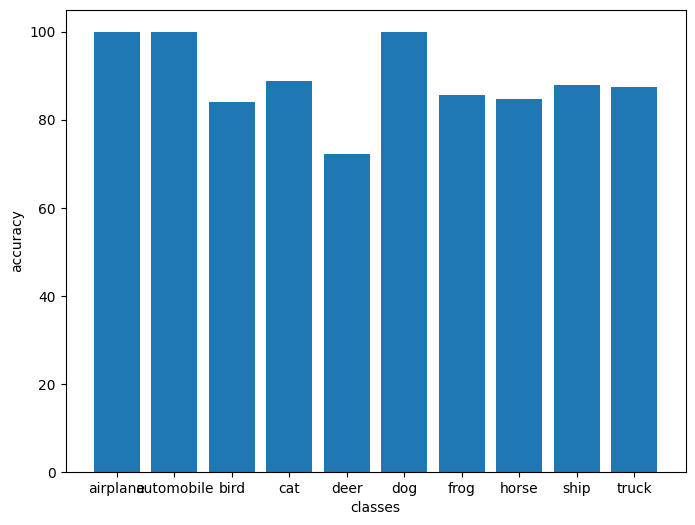

In [13]:
calculate_accuracy_per_class(model,device,test_loader,test)

In [14]:
torch.save(model.state_dict(), "cifar_85.pth")